In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
tf.__version__

'2.8.2'

**포지셔널 인코딩**

In [ ]:
# 최종 버전
class PositionalEncoding(tf.keras.layers.Layer):
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :], # 0 ~ d_model
        d_model=d_model)

    # 배열의 짝수 인덱스(2i)에는 사인 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])

    # 배열의 홀수 인덱스(2i+1)에는 코사인 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    angle_rads = np.zeros(angle_rads.shape)
    angle_rads[:, 0::2] = sines
    angle_rads[:, 1::2] = cosines
    
    pos_encoding = tf.constant(angle_rads)
    print(pos_encoding.shape)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    print(pos_encoding.shape)
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 128)
sample_pos_encoding.pos_encoding.numpy()

(50, 128)
(1, 50, 128)


array([[[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00],
        [ 8.41471016e-01,  5.40302277e-01,  7.61720419e-01, ...,
          1.00000000e+00,  1.15478222e-04,  1.00000000e+00],
        [ 9.09297466e-01, -4.16146815e-01,  9.87046242e-01, ...,
          9.99999940e-01,  2.30956444e-04,  1.00000000e+00],
        ...,
        [ 1.23573124e-01, -9.92335498e-01,  1.39922664e-01, ...,
          9.99980330e-01,  5.42744994e-03,  9.99985278e-01],
        [-7.68254697e-01, -6.40144348e-01, -6.63569212e-01, ...,
          9.99979496e-01,  5.54292602e-03,  9.99984622e-01],
        [-9.53752637e-01,  3.00592542e-01, -9.99784708e-01, ...,
          9.99978662e-01,  5.65840257e-03,  9.99983966e-01]]],
      dtype=float32)

**Scaled Dot-Production Attention**

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
  # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
  # padding_mask : (batch_size, 1, 1, key의 문장 길이)

  # Q와 K의 곱. 어텐션 스코어 행렬.
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 스케일링
  # dk의 루트값으로 나눠준다.
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 마스킹. 어텐션 스코어 행렬의 마스킹 할 위치에 매우 작은 음수값을 넣는다.
  # 매우 작은 값이므로 소프트맥스 함수를 지나면 행렬의 해당 위치의 값은 0이 된다.
  if mask is not None:
    logits += (mask * -1e9)

  # 소프트맥스 함수는 마지막 차원인 key의 문장 길이 방향으로 수행된다.
  # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
  output = tf.matmul(attention_weights, value)

  return output, attention_weights

**MultiHeadAttention**

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    # d_model을 num_heads로 나눈 값.
    # 논문 기준 : 64
    self.depth = d_model // self.num_heads

    # WQ, WK, WV에 해당하는 밀집층 정의
    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    # WO에 해당하는 밀집층 정의
    self.dense = tf.keras.layers.Dense(units=d_model)

  # num_heads 개수만큼 q, k, v를 split하는 함수
  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # 1. WQ, WK, WV에 해당하는 밀집층 지나기
    # q : (batch_size, query의 문장 길이, d_model)
    # k : (batch_size, key의 문장 길이, d_model)
    # v : (batch_size, value의 문장 길이, d_model)
    # 참고) 인코더(k, v)-디코더(q) 어텐션에서는 query 길이와 key, value의 길이는 다를 수 있다.
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 2. 헤드 나누기
    # q : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # k : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # v : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 3. 스케일드 닷 프로덕트 어텐션. 앞서 구현한 함수 사용.
    # (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
    # (batch_size, query의 문장 길이, num_heads, d_model/num_heads)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 4. 헤드 연결(concatenate)하기
    # (batch_size, query의 문장 길이, d_model)
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 5. WO에 해당하는 밀집층 지나기
    # (batch_size, query의 문장 길이, d_model)
    outputs = self.dense(concat_attention)

    return outputs

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, key의 문장 길이)
  return mask[:, tf.newaxis, tf.newaxis, :]

**인코더**

In [ ]:
def encoder_layer(dff, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 인코더는 패딩 마스크 사용 -> 어텐션에서 패딩 토큰 제외
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 멀티-헤드 어텐션 (첫번째 서브층 / 셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': padding_mask # 패딩 마스크 사용
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 포지션 와이즈 피드 포워드 신경망 (두번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

실제로 트랜스포머는 num_layers 개수만큼의 인코더 층을 사용하므로 이를 여러번 쌓는 코드를 별도 구현합니다. 

In [ ]:
def encoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 인코더는 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 인코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = encoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

**디코더**

In [ ]:
# 디코더의 첫번째 서브층(sublayer)에서 미래 토큰을 Mask하는 함수
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0) #  Lower triangular part.
  padding_mask = create_padding_mask(x) # 패딩 마스크도 포함
  return tf.maximum(look_ahead_mask, padding_mask)

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))


tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


In [ ]:
def decoder_layer(dff, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 멀티-헤드 어텐션 (첫번째 서브층 / 마스크드 셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs, 'key': inputs, 'value': inputs, # Q = K = V
          'mask': look_ahead_mask # 룩어헤드 마스크
      })

  # 잔차 연결과 층 정규화
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 멀티-헤드 어텐션 (두번째 서브층 / 디코더-인코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1, 'key': enc_outputs, 'value': enc_outputs, # Q != K = V
          'mask': padding_mask # 패딩 마스크
      })

  # 드롭아웃 + 잔차 연결과 층 정규화
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 포지션 와이즈 피드 포워드 신경망 (세번째 서브층)
  outputs = tf.keras.layers.Dense(units=dff, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 드롭아웃 + 잔차 연결과 층 정규화
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

포지셔널 인코딩 후 디코더 층을 num_layers의 개수만큼 쌓는 코드입니다.

In [ ]:
def decoder(vocab_size, num_layers, dff,
            d_model, num_heads, dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

  # 디코더는 룩어헤드 마스크(첫번째 서브층)와 패딩 마스크(두번째 서브층) 둘 다 사용.
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 포지셔널 인코딩 + 드롭아웃
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # 디코더를 num_layers개 쌓기
  for i in range(num_layers):
    outputs = decoder_layer(dff=dff, d_model=d_model, num_heads=num_heads,
        dropout=dropout, name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

**트랜스포머 구현하기**

In [ ]:
def transformer(vocab_size, num_layers, dff,
                d_model, num_heads, dropout,
                name="transformer"):

  # 인코더의 입력
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 디코더의 입력
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더의 패딩 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더의 룩어헤드 마스크(첫번째 서브층)
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask, output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 디코더의 패딩 마스크(두번째 서브층)
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

##################################################################

  # 인코더의 출력은 enc_outputs. 디코더로 전달된다.
  enc_outputs = encoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[inputs, enc_padding_mask]) # 인코더의 입력은 입력 문장과 패딩 마스크

  # 디코더의 출력은 dec_outputs. 출력층으로 전달된다.
  dec_outputs = decoder(vocab_size=vocab_size, num_layers=num_layers, dff=dff,
      d_model=d_model, num_heads=num_heads, dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 다음 단어 예측을 위한 출력층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
y_true = 1
tf.cast(tf.not_equal(y_true, 0), tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=1.0>

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32) # y_true가 0(패딩이면) -> 0 , 1이면 -> 1
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss) #Computes the mean of elements across dimensions of a tensor.

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# 모델 학습

In [ ]:
import pandas as pd
import urllib.request
import tensorflow_datasets as tfds
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt
import re

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/trans_koreng_project/songs/전처리_노래제목&가사(벅스).csv')
train_data.head()

,Unnamed: 0,title,lylic
0,0,천만분의 1의 확률의 너,Every seconds Every minutes 너를 만나기 위해 모든 시간들을...
1,1,술이 뭐길래,오늘도 이렇게 어제처럼 잔을 꺼내 나 혼자서 따른 잔에 내 입술을 기대 눈물 반 ...
2,2,그때 그 순간 그대로,잘 지냈지 조금은 어색해 요즘 좋아 보여 인사 나누며 사실 궁금한 게 너무 많았는...
3,3,나의 X에게,우리 다시 만날래 예쁘게 빛나던 모든 추억들이 너무 그리워 너의 품에 안길래 이 ...
4,4,일과 이분의 일,멀리서 널 보았을 때 다른 길로 갈까 생각했는데 변한 듯한 널 보고 싶고 짧은 인...


In [ ]:
train_data

,Unnamed: 0,title,lylic
0,0,천만분의 1의 확률의 너,Every seconds Every minutes 너를 만나기 위해 모든 시간들을...
1,1,술이 뭐길래,오늘도 이렇게 어제처럼 잔을 꺼내 나 혼자서 따른 잔에 내 입술을 기대 눈물 반 ...
2,2,그때 그 순간 그대로,잘 지냈지 조금은 어색해 요즘 좋아 보여 인사 나누며 사실 궁금한 게 너무 많았는...
3,3,나의 X에게,우리 다시 만날래 예쁘게 빛나던 모든 추억들이 너무 그리워 너의 품에 안길래 이 ...
4,4,일과 이분의 일,멀리서 널 보았을 때 다른 길로 갈까 생각했는데 변한 듯한 널 보고 싶고 짧은 인...
...,...,...,...
41881,41881,뚜벅뚜벅,오늘도 뚜벅뚜벅 발길은 너무나 막연해 우리 이렇게 멀리 왔어도 느린 걸음으로 따라...
41882,41882,해피 크리스마스,혼자 있는 이 세상 빛이 없다 믿나요 기댈 곳 없어 두 뺨 위에 눈물만 힘든 발걸...
41883,41883,Stegosaurus,One two three four five It’s a pentagon One t...
41884,41884,붕붕붕 스쿨버스 안전송,헤헷 오늘도 안전하게 출발 스쿨비가 달려요 붕붕붕 붕붕붕 스쿨비가 달려요 붕붕 붕...


In [ ]:
print(train_data.isnull().sum())

Unnamed: 0     0
title         26
lylic          0
dtype: int64


In [ ]:
train_data.drop_duplicates(subset=['lylic'], inplace=True)
train_data.dropna(inplace=True)

In [ ]:
print(train_data.isnull().sum())

Unnamed: 0    0
title         0
lylic         0
dtype: int64


In [ ]:
print('가사 샘플의 개수 :', len(train_data))

가사 샘플의 개수 : 25626


In [ ]:
lyric = []
for sentence in train_data['lylic']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    lyric.append(sentence)

In [ ]:
title = []
for sentence in train_data['title']:
    # 구두점에 대해서 띄어쓰기
    # ex) 12시 땡! -> 12시 땡 !
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = sentence.strip()
    title.append(sentence)

In [ ]:
title[0]

'천만분의 1의 확률의 너'

In [ ]:
len(lyric) , len(title)

(25626, 25626)

In [ ]:
len(lyric[0].split(' '))

169

In [ ]:
cut_lyric = []
cut_title = []

for i in range(len(lyric)) :
  token_lyric = len(lyric[i].split(' '))
  token_title = len(title[i].split(' '))
  if token_lyric <= 450 :
    cut_lyric.append(lyric[i])
    cut_title.append(title[i])


In [ ]:
len(cut_lyric), len(cut_title)

(25423, 25423)

In [ ]:
print(cut_lyric[:5])
print(cut_title[:5])

['Every seconds Every minutes 너를 만나기 위해 모든 시간들을 모래시계에 다 넣어 놓고서 우리 둘만의 이야기를 나눌 거야 기억을 건너 그 순간 그때 널 만날 수 있게 되면 아마도 기적과 같은 일이 아닐까 멈춰버린 내 시간 속에서 마침내 너를 발견한 건 천만분의 1 수많은 시행착오 그 끝에 마지막이라고 생각한 그때 우연이 아닌 운명처럼 모든 게 딱 맞아떨어진 그때 흐려진 시야 속 짙게 밴 네 향이 이끌어 너에게 자석처럼 당겨 세게 그곳에 더 닿을게 붉게 물들어 이곳엔 언제나 그랬듯 내겐 아프더라도 난 괜찮아 오직 너니까 우리 둘만의 이야기를 나눌 거야 기억을 건너 그 순간 그때 널 만날 수 있게 되면 아마도 기적과 같은 일이 아닐까 멈춰버린 내 시간 속에서 마침내 너를 발견한 건 천만분의 1 우리 만남을 위해 사계절을 달려 달력을 다 찢어내 수많은 인파 속 숨어있던 꽃 그게 너였기에 빛이나 더 빛이나 화려함보단 익숙한 곳 변하지 않을 수 있을까 그 순간 그때 널 만날 수 있게 되면 빛바랜 사진 속 웃고 있는 우리 둘 추억이라 말할 수 있는 그런 날이 오길 그때의 온도 그때의 하늘 노을빛마저 기억할 수 있을까', '오늘도 이렇게 어제처럼 잔을 꺼내 나 혼자서 따른 잔에 내 입술을 기대 눈물 반 소주 반 흘리고 또 비우고 얼마나 마셔야 겨우 잠들 수 있을까 나를 많이 사랑한 사람 너라서 난 좋았는데 너보다 더 나은 남자 못 만날 텐데 술이 뭐길래 난 잊으려 마신 술인데 이 술이 뭐길래 널 자꾸 더 생각나게 해 너와 내가 헤어진 후 늘어버린 두 가지는 술 그리고 그리움 오늘도 이렇게 버릇처럼 잔을 꺼내 어제보다 많은 술에 몸을 기대려 해 한숨 반 소주 반 내쉬고 또 채우고 얼마나 마셔야 겨우 취할 수 있을까 나를 많이 사랑한 사람 너라서 난 좋았는데 너보다 더 나은 여자 못 만날 텐데 술이 뭐길래 난 잊으려 마신 술인데 이 술이 뭐길래 널 자꾸 더 생각나게 해 너와 내가 헤어진 후 늘어버린 두 가지는 술 그리고 그리움 나 때문에 우린 내 잘못 

In [ ]:
# 서브워드텍스트인코더를 사용하여 가사와 제목을 모두 포함한 단어 집합(Vocabulary) 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    cut_lyric + cut_title, target_vocab_size=2**13)
    #lyric + title, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰에 대한 정수 부여.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# 시작 토큰과 종료 토큰을 고려하여 단어 집합의 크기를 + 2
VOCAB_SIZE = tokenizer.vocab_size + 2

In [ ]:
print('시작 토큰 번호 :',START_TOKEN)
print('종료 토큰 번호 :',END_TOKEN)
print('단어 집합의 크기 :',VOCAB_SIZE)

시작 토큰 번호 : [8126]
종료 토큰 번호 : [8127]
단어 집합의 크기 : 8128


In [ ]:
len(tokenizer.subwords)

7869

In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()를 사용하여 텍스트 시퀀스를 정수 시퀀스로 변환.
print('Tokenized sample question: {}'.format(tokenizer.encode(cut_lyric[1])))

Tokenized sample question: [335, 135, 1287, 59, 7270, 4322, 19, 2382, 515, 1037, 603, 14, 1, 6934, 3158, 541, 4341, 188, 1624, 4341, 2802, 6, 50, 134, 3869, 726, 4206, 48, 4647, 5141, 18, 475, 36, 350, 1899, 149, 4159, 7, 1976, 248, 228, 260, 32, 86, 21, 1825, 174, 1357, 948, 4098, 7902, 1837, 5870, 7, 4741, 7902, 168, 748, 1103, 1478, 2, 4098, 7902, 1837, 5870, 28, 310, 32, 3155, 17, 29, 102, 30, 7043, 7902, 1243, 2534, 267, 146, 1086, 9, 2133, 1044, 3227, 335, 135, 7234, 59, 7270, 4322, 7109, 390, 5944, 1527, 1078, 205, 29, 5022, 4341, 188, 1624, 4341, 141, 5363, 50, 3178, 6, 726, 4206, 48, 4647, 1517, 74, 18, 475, 36, 350, 1899, 149, 4159, 7, 1976, 248, 228, 260, 32, 86, 21, 1255, 174, 1357, 948, 4098, 7902, 1837, 5870, 7, 4741, 7902, 168, 748, 1103, 1478, 2, 4098, 7902, 1837, 5870, 28, 310, 32, 3155, 17, 29, 102, 30, 7043, 7902, 1243, 2534, 267, 146, 1086, 9, 2133, 1044, 3227, 19, 986, 148, 1, 1792, 7902, 986, 4607, 7902, 1266, 49, 279, 2961, 591, 2102, 152, 4098, 7902, 1837, 5870,

In [ ]:
count=[]
for i in range(len(cut_lyric)):
  token = tokenizer.encode(cut_lyric[i])
  count.append(len(token))

In [ ]:
count[0:10]

[248, 234, 234, 180, 254, 266, 186, 199, 251, 188]

In [ ]:
len(tokenizer.encode(cut_lyric[0]))

248

In [ ]:
max(count)

2359

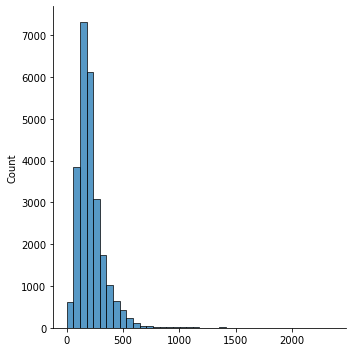

In [ ]:
import seaborn as sns
sns.displot(count, bins=40)

In [ ]:
count = np.array(count) 

In [ ]:
sum(np.where(count<350, 1, 0)) /len(count)

0.8910435432482398

In [ ]:
sum(np.where(count<400, 1, 0)) /len(count)

0.9273099162175983

In [ ]:
sum(np.where(count<450, 1, 0)) /len(count)

0.9517759509105927

In [ ]:
sum(np.where(count<500, 1, 0)) /len(count)

0.9699484718561933

In [ ]:
# 서브워드텍스트인코더 토크나이저의 .encode()와 decode() 테스트해보기

# 임의의 입력 문장을 sample_string에 저장
sample_string = cut_lyric[20]

# encode() : 텍스트 시퀀스 --> 정수 시퀀스
tokenized_string = tokenizer.encode(sample_string)
print ('정수 인코딩 후의 문장 {}'.format(tokenized_string))

# decode() : 정수 시퀀스 --> 텍스트 시퀀스
original_string = tokenizer.decode(tokenized_string)
print ('기존 문장: {}'.format(original_string))

정수 인코딩 후의 문장 [3186, 148, 2891, 74, 77, 54, 3646, 4247, 686, 104, 481, 898, 17, 28, 1965, 10, 3821, 1715, 3646, 2090, 2577, 2854, 195, 10, 161, 1611, 2456, 4695, 266, 382, 17, 102, 1537, 37, 20, 109, 363, 128, 7155, 6, 370, 640, 4439, 1, 3342, 960, 32, 1297, 20, 1299, 1579, 20, 32, 3962, 17, 32, 266, 382, 17, 3022, 28, 4255, 1123, 2046, 807, 604, 19, 135, 167, 1594, 81, 180, 3627, 176, 50, 2499, 191, 882, 197, 3946, 28, 3718, 28, 956, 3869, 5556, 224, 1089, 8, 128, 960, 43, 3358, 46, 1899, 584, 911, 5033, 6, 72, 351, 1647, 6101, 824, 102, 236, 738, 2014, 4372, 2624, 140, 1055, 824, 515, 60, 1291, 515, 60, 126, 37, 17, 4378, 245, 20, 2176, 909, 59, 4924, 93, 118, 1429, 148, 2572, 6, 1429, 148, 659, 675, 174, 921, 2795, 64, 180, 3627, 176, 50, 2499, 191, 882, 197, 3946, 28, 3718, 28, 956, 3869, 5556, 224, 1089, 8, 128, 960, 43, 3358, 46, 1899, 584, 911, 5033, 6, 72, 351, 1647, 6101, 824, 56, 45, 2040, 59, 5160, 12, 5481, 198, 4204, 6047, 429, 200, 1194, 931, 2110, 18, 475, 2626, 93, 235, 

In [ ]:
# 각 정수는 각 단어와 어떻게 mapping되는지 병렬로 출력
# 서브워드텍스트인코더는 의미있는 단위의 서브워드로 토크나이징한다. 띄어쓰기 단위 X 형태소 분석 단위 X
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

In [ ]:
# 최대 길이를 350으로 정의
MAX_LENGTH = 350

# 토큰화 / 정수 인코딩 / 시작 토큰과 종료 토큰 추가 / 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # encode(토큰화 + 정수 인코딩), 시작 토큰과 종료 토큰 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    tokenized_inputs.append(sentence1)
    tokenized_outputs.append(sentence2)
  
  # 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [ ]:
lyric, title = tokenize_and_filter(cut_lyric, cut_title)

In [ ]:
print('질문 데이터의 크기(shape) :', lyric.shape)
print('답변 데이터의 크기(shape) :', title.shape)

질문 데이터의 크기(shape) : (25423, 350)
답변 데이터의 크기(shape) : (25423, 350)


In [ ]:
# 0번째 샘플을 임의로 출력
print(lyric[0])
print(title[0])

[8126 2022 4233 1354 1710 2022 1908 1629  388   46 4770 7902  383   91
 3500    8 2461 2480   14   10 5061 7902  655  962   45 2804 1604   34
   86 5745 7902   64 3168 2812   15  322  671   28 1357   18  586 1817
 3186 1930  121   94 1483 4766 6092    1  321  717 5203    1   46  360
 2173   12  113  549  221  688   24 1459 1005  110  952 2234  157   15
  975 5778  686  925   12  671 2938    2  576 5913   91   17  844  554
   92 7183  671 3796   83  110   48  407 8106 8037 8023   17 8105 8046
 8050 7902   22  968    2 3404   53  239  126 1312   59 7132 7902  332
   17 3448   32 7131   17 4254 4615 2210  162  293 1219  164  582 1696
 2805    7  528  850  228  401   45 2804 1604   34   86 5745 7902   64
 3168 2812   15  322  671   28 1357   18  586 1817 3186 1930  121   94
 1483 4766 6092    1  321  717 5203    1   46  360 2173   12  113  549
  221  688   24 1459   45 3858    8  383  115 1649    8 1321  251 1999
    8   10 7376    1 1005  233 1476  407 3540  949  692  543 4032 1545
 6522 

In [ ]:
print('단어 집합의 크기(Vocab size): {}'.format(VOCAB_SIZE))
print('전체 샘플의 수(Number of samples): {}'.format(len(lyric)))

단어 집합의 크기(Vocab size): 8128
전체 샘플의 수(Number of samples): 25423


In [ ]:
# 텐서플로우 dataset을 이용하여 셔플(shuffle)을 수행하되, 배치 크기로 데이터를 묶는다.
# 또한 이 과정에서 교사 강요(teacher forcing)을 사용하기 위해서 디코더의 입력과 실제값 시퀀스를 구성한다.
BATCH_SIZE = 32
BUFFER_SIZE = 20000

# 디코더의 실제값 시퀀스에서는 시작 토큰을 제거해야 한다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': lyric,
        'dec_inputs': title[:, :-1] # 디코더의 입력. 마지막 패딩 토큰이 제거된다.
    },
    {
        'outputs': title[:, 1:]  # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다.
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# 임의의 샘플에 대해서 [:, :-1]과 [:, 1:]이 어떤 의미를 가지는지 테스트해본다.
print(title[0]) # 기존 샘플
print(title[:1][:, :-1]) # 마지막 패딩 토큰 제거하면서 길이가 39가 된다.
print(title[:1][:, 1:]) # 맨 처음 토큰이 제거된다. 다시 말해 시작 토큰이 제거된다. 길이는 역시 39가 된다.

[8126  549  221  688   24 7919   24 2425 8105 8035 8030   24  228 8127
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

# **NUM_LAYERS에서 인코딩 & 디코딩 층을 정할수 있다.**

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 4
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.3

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    dff=DFF,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

(8128, 256)
(1, 8128, 256)
(8128, 256)
(1, 8128, 256)


In [ ]:
MAX_LENGTH = 350

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
EPOCHS = 1

model.fit(dataset, epochs=EPOCHS)

795/795 [==============================] - 670s 793ms/step - loss: 0.1046 - accuracy: 0.0028


In [ ]:
def evaluate(sentence):
  sentence = preprocess_sentence(sentence)

  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  output = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 예측 시작
  for i in range(MAX_LENGTH):
    predictions = model(inputs=[sentence, output], training=False)

    # 현재(마지막) 시점의 예측 단어를 받아온다.
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 마지막 시점의 예측 단어가 종료 토큰이라면 예측을 중단
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 마지막 시점의 예측 단어를 출력에 연결한다.
    # 이는 for문을 통해서 디코더의 입력으로 사용될 예정이다.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)


def predict(sentence):
  prediction = evaluate(sentence)

  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('가사: {}'.format(sentence))
  print('예측 제목: {}'.format(predicted_sentence))

  return predicted_sentence

In [ ]:
def preprocess_sentence(sentence):
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
#벚꽃엔딩 - 버스커버스커 
output = predict("""
그대여 그대여 그대여 그대여 그대여
오늘은 우리 같이 걸어요 이 거리를
밤에 들려오는 자장노래 어떤가요 
몰랐던 그대와 단 둘이 손 잡고
알 수 없는 이 떨림과 둘이 걸어요

봄바람 휘날리며
흩날리는 벚꽃 잎이
울려 퍼질 이 거리를
둘이 걸어요

그대여 우리 이제 손 잡아요 이 거리에
마침 들려오는 사랑 노래 어떤가요
사랑하는 그대와 단둘이 손잡고
알 수 없는 이 거리를 둘이 걸어요

바람 불면 울렁이는 기분 탓에 나도 모르게
바람 불면 저편에서 그대여 니 모습이 자꾸 겹쳐
오 또 울렁이는 기분 탓에 나도 모르게
바람 불면 저편에서 그대여 니 모습이 자꾸 겹쳐

사랑하는 연인들이 많군요 알 수 없는 친구들이 많아요
흩날리는 벚꽃 잎이 많군요 좋아요

봄바람 휘날리며
흩날리는 벚꽃 잎이
울려 퍼질 이 거리를
둘이 걸어요
"""
)

In [ ]:
#한숨 - 이하이 
output = predict("""
숨을 크게 쉬어봐요
당신의 가슴 양쪽이 저리게
조금은 아파올 때까지
숨을 더 뱉어봐요
당신의 안에 남은 게 없다고
느껴질 때까지
숨이 벅차올라도 괜찮아요
아무도 그댈 탓하진 않아
가끔은 실수해도 돼
누구든 그랬으니까
괜찮다는 말
말뿐인 위로지만
누군가의 한숨
그 무거운 숨을
내가 어떻게
헤아릴 수가 있을까요
당신의 한숨
그 깊일 이해할 순 없겠지만
괜찮아요
내가 안아줄게요
누군가의 한숨
그 무거운 숨을
내가 어떻게
헤아릴 수가 있을까요
당신의 한숨
"""
)

In [ ]:
#형 - 노라조 
output = predict("""
삶이란 시련과 같은 말이야
고개 좀 들고 어깨펴 짜샤
형도 그랬단다 죽고 싶었지만
견뎌 보니 괜찮더라
맘껏 울어라 억지로 버텨라
내일은 내일의 해가 뜰테니
바람이 널 흔들고 소나기 널 적셔도
살아야 갚지 않겠니
더 울어라 젊은 인생아
져도 괜찮아 넘어지면 어때
살다보면 살아가다 보면
웃고 떠들며 이날을 넌 추억할테니
세상에 혼자라 느낄테지
"""
)

In [ ]:
#나는 반딧불 - 중식이 //국대위 픽
output = predict("""
나는 내가 빛나는 별인 줄 알았어요
한 번도 의심한 적 없었죠
몰랐어요 난 내가 벌레라는 것을
그래도 괜찮아 난 눈부시니까
하늘에서 떨어진 별인 줄 알았어요
소원을 들어주는 작은 별
몰랐어요 난 내가 개똥벌레라는 것을
그래도 괜찮아 나는 빛날 테니까
나는 내가 빛나는 별인 줄 알았어요
한 번도 의심한 적 없었죠
몰랐어요 난 내가 벌레라는 것을
그래도 괜찮아 난 눈부시니까
한참 동안 찾았던 내 손톱
하늘로 올라가 초승달 돼 버렸지
주워 담을 수도 없게 너무 멀리 갔죠
누가 저기 걸어놨어 누가 저기 걸어놨어
우주에서 무주에서 날아온
밤하늘의 별들이 반딧불이 돼 버렸지
내가 널 만난 것처럼 마치 약속한 것처럼
나는 다시 태어났지 나는 다시 태어났지
나는 내가 빛나는 별인 줄 알았어요
한 번도 의심한 적 없었죠
몰랐어요 난 내가 벌레라는 것을
그래도 괜찮아 난 눈부시니까
하늘에서 떨어진 별인 줄 알았어요
소원을 들어주는 작은 별
몰랐어요 난 내가 개똥벌레란 것을
그래도 괜찮아 나는 빛날 테니까
"""
)

In [ ]:
#결혼해줄래? - 이승기
output = predict("""
나랑 결혼 해 줄래? 나랑 평생을 함께 살래?
우리 둘이 알콩달콩 서로 사랑하며
나 닮은 아이 하나
너 닮은 아이 하나 낳고
천년만년 아프지 말고 난 살고 싶은데
솔직히 말해서 내가 널 더 좋아해
남자와 여자 사이엔 그게 좋다고 하던데
내가 더 사랑할게 내가 더 아껴줄게
눈물이 나고 힘이 들 때면
아플 때면 함께 아파할게
평생을 사랑할게 평생을 지켜줄게
너만큼 좋은 사람 만난 걸 감사해
매일 너만 사랑하고 싶어
나랑 결혼해 줄래
"""
)

In [ ]:
#사랑을 했다 - 아이콘
output = predict("""
사랑을 했다 우리가 만나
지우지 못할 추억이 됐다
볼만한 멜로드라마, 괜찮은 결말
그거면 됐다, 널 사랑했다
우리가 만든 love scenario
이젠 조명이 꺼지고
마지막 페이지를 넘기면
조용히 막을 내리죠
에이, 괜찮지만은 않아 이별을 마주한다는 건
오늘이었던 우리의 어제에 더는 내일이 없다는 건
아프긴 해도 더 끌었음 상처가 덧나니까
널 사랑했고 사랑 받았으니 난 이걸로 됐어
나 살아가면서 가끔씩 떠오를 기억
그 안에 네가 있다면 그거면 충분해
사랑을 했다 우리가 만나
지우지 못할 추억이 됐다
볼만한 멜로드라마, 괜찮은 결말
그거면 됐다, 널 사랑했다
"""
)

In [ ]:
#광대 - 리쌍
output = predict("""
오- 내가 웃고 있나요? 
모두 거짓이겠죠?
날 보는 이들의 눈빛 속에는 
슬픔이 젖어있는데.
내 이름은 광대, 내 직업은 수많은 관객,
그 앞에 웃음을 파는 일
슬퍼도 웃으며 내 모습을 감추는 게 철칙.
오- 이런 내 처질, 손가락질 하며 날 모욕해도
더 크게 웃고 난 땀으로 목욕하고
음악이 꺼지고 막이 내리고 밤이 오면
별빛에 몸을 씻고 눈부시게
광낸 구두를 신고 달에게 청혼하듯 손
을 내밀어 얼음 위를 미끄러지듯
앞으로 달려  아무도 모르게
조용히 흐르는 이 시간에
외롭게 홀로 핀 꽃 한 송이에 난 반해
사랑을 나누려 나는 간다네
"""
)

In [ ]:
#청춘 - 김필
output = predict("""
언젠간 가겠지 푸르른 이 청춘
지고 또 피는 꽃잎처럼
달밝은 밤이면 창가에 흐르는
내 젊은 연가가 구슬퍼
가고없는 날들을 잡으려 잡으려
빈손짓에 슬퍼지면
차라리 보내야지 돌아서야지
그렇게 세월은 가는거야
나를 두고 간님은 용서하겠지만
날 버리고 가는 세월이야
정둘곳없어라 허전한 마음은
정답던 옛동산 찾는가
언젠간 가겠지 푸르른 이 청춘
지고 또 피는 꽃잎처럼
달밝은 밤이면 창가에 흐르는
내 젊은 연가가 구슬퍼
가고없는 날들을 잡으려 잡으려
빈손짓에 슬퍼지면
차라리 보내야지 돌아서야지
그렇게 세월은 가는거야
언젠간 가겠지 푸르른 이 청춘
지고 또 피는 꽃잎처럼
달밝은 밤이면 창가에 흐르는
내 젊은 연가가 구슬퍼
"""
)

In [ ]:
#다시만난세계 - 소녀시대
output = predict("""
전해주고 싶어 슬픈 시간이 다 흩어진 후에야 들리지만
눈을 감고 느껴봐 움직이는 마음 너를 향한 내 눈빛을
특별한 기적을 기다리지마 눈 앞에선 우리의 거친 길은
알 수 없는 미래와 벽 바꾸지 않아 포기할 수 없어
변치 않을 사랑으로 지켜줘 상처 입은 내 맘까지
시선 속에서 말은 필요 없어 멈춰져 버린 이 시간
사랑해 널 이 느낌 이대로 그려왔던 헤매임의 끝
이 세상 속에서 반복되는 슬픔 이젠 안녕
수많은 알 수 없는 길 속에 희미한 빛을 난 쫓아가
언제까지라도 함께 하는거야 다시 만난 나의 세계
특별한 기적을 기다리지마 눈 앞에선 우리의 거친 길은
알 수 없는 미래와 벽 바꾸지 않아 포기할 수 없어
변치 않을 사랑으로 지켜줘 상처 입은 내 맘까지
시선 속에서 말은 필요 없어 멈춰져 버린 이 시간
사랑해 널 이 느낌 이대로 그려왔던 헤매임의 끝
이 세상 속에서 반복되는 슬픔 이젠 안녕
수많은 알 수 없는 길 속에 희미한 빛을 난 쫓아가
언제까지라도 함께 하는거야 다시 만난 우리의
이렇게 까만 밤 홀로 느끼는 그대의 부드러운 숨결이
이 순간 따스하게 감겨오는 모든 나의 떨림 전할래
사랑해 널 이 느낌 이대로 그려왔던 헤매임의 끝
이 세상 속에서 반복되는 슬픔 이젠 안녕
널 생각만 해도 난 강해져 울지 않게 나를 도와줘
이 순간의 느낌 함께 하는거야 다시 만난 우리의
"""
)

In [ ]:
#제목 - 사람
output = predict("""

"""
)

In [ ]:
#꽃길 - 빅뱅
output = predict("""
그땐 참 좋았는데 말이야
너와 함께할 수만 있다면
때론 외롭고 슬퍼도 말이야
너와 같이 할 수만 있다면
Sing it na na na
노래해 나나나
우리 이게 마지막이 아니야
부디 또 만나요 꽃이 피면
때론 꽤 별난 일이 많아
넌 나 같이 못난 놈을 만나
다시 누군갈 사랑할 수 있을까?
너 아니라면 그럴 일은 없을 것 같아
나 의식 없이 발길 흐름대로 가던 길
날 화려히 비춰주던 네 빛 한줄기
그 전율이 느껴지는 예쁜 꽃 길
그곳에 너로 인해 설수 있던 Roly poly toy
떠나려거든 보내 드리오리다
님이 가시는 길에 꽃을 뿌리오리다
그리워지면 돌아와 줘요
그때 또 다시 날 사랑해줘요
이 꽃 길 따라 잠시 쉬어가다가
그 자리 그곳에서 날 기다려요
그땐 참 좋았는데 말이야
너와 함께할 수만 있다면
때론 외롭고 슬퍼도 말이야
너와 같이 할 수만 있다면
많이 울기도 했지만 웃은 일도 많아
내 머릿속 안에는 추억이 너무 많아
이 또한 지나갈 테니까
이 다음에 만나요 꽃이 피면
1년 365 이 세상 하나뿐인
넌 내 음악의 Motive 날 일깨워주는 은인
네 커다란 꽃밭에 기대어 막 떠오르던 가사말
아직도 참 생생해 빠담빠담
너란 만개 한 꽃의 색은 100000 개
무한대 거대한 울림 Vivaldi의 사계
아직도 그댄 내 맘에 담을 수 없는 그림
내 눈을 의심하지 You are my Magical Queen
떠나려거든 보내 드리오리다
님이 가시는 길에 꽃을 뿌리오리다
그리워지면 돌아와 줘요
그때 또 다시 날 사랑해줘요
이 꽃 길 따라 잠시 쉬어가다가
그 자리 그곳에서 날 기다려요
꽃 잎 따다 입을 맞추죠 얼굴은 빨개지고
꽃 길을 깔아 준비를 하죠 그대가 오시는 길
그리워지면 돌아와 줘요
그때 또 다시 날 사랑해줘요
이 꽃 길 따라 잠시 쉬어가다가
그 자리 그곳에서 날 기다려요
꽃 잎 따다 입을 맞추죠 얼굴은 빨개지고
꽃 길을 깔아 준비를 하죠
그 자리 그곳에서 날 기다려요
"""
)

In [ ]:
#꽃길 - 김세정
output = predict("""
그땐 참 좋았는데 말이야
너와 함께할 수만 있다면
때론 외롭고 슬퍼도 말이야
너와 같이 할 수만 있다면
Sing it na na na
노래해 나나나
우리 이게 마지막이 아니야
부디 또 만나요 꽃이 피면
때론 꽤 별난 일이 많아
넌 나 같이 못난 놈을 만나
다시 누군갈 사랑할 수 있을까?
너 아니라면 그럴 일은 없을 것 같아
나 의식 없이 발길 흐름대로 가던 길
날 화려히 비춰주던 네 빛 한줄기
그 전율이 느껴지는 예쁜 꽃 길
그곳에 너로 인해 설수 있던 Roly poly toy
떠나려거든 보내 드리오리다
님이 가시는 길에 꽃을 뿌리오리다
그리워지면 돌아와 줘요
그때 또 다시 날 사랑해줘요
이 꽃 길 따라 잠시 쉬어가다가
그 자리 그곳에서 날 기다려요
그땐 참 좋았는데 말이야
너와 함께할 수만 있다면
때론 외롭고 슬퍼도 말이야
너와 같이 할 수만 있다면
많이 울기도 했지만 웃은 일도 많아
내 머릿속 안에는 추억이 너무 많아
이 또한 지나갈 테니까
이 다음에 만나요 꽃이 피면
1년 365 이 세상 하나뿐인
넌 내 음악의 Motive 날 일깨워주는 은인
네 커다란 꽃밭에 기대어 막 떠오르던 가사말
아직도 참 생생해 빠담빠담
너란 만개 한 꽃의 색은 100000 개
무한대 거대한 울림 Vivaldi의 사계
아직도 그댄 내 맘에 담을 수 없는 그림
내 눈을 의심하지 You are my Magical Queen
떠나려거든 보내 드리오리다
님이 가시는 길에 꽃을 뿌리오리다
그리워지면 돌아와 줘요
그때 또 다시 날 사랑해줘요
이 꽃 길 따라 잠시 쉬어가다가
그 자리 그곳에서 날 기다려요
꽃 잎 따다 입을 맞추죠 얼굴은 빨개지고
꽃 길을 깔아 준비를 하죠 그대가 오시는 길
그리워지면 돌아와 줘요
그때 또 다시 날 사랑해줘요
이 꽃 길 따라 잠시 쉬어가다가
그 자리 그곳에서 날 기다려요
꽃 잎 따다 입을 맞추죠 얼굴은 빨개지고
꽃 길을 깔아 준비를 하죠
그 자리 그곳에서 날 기다려요
"""
)

In [ ]:
#슈퍼맨 - 노라조
output = predict("""
아들아 지구를 부탁하노라
아버지 걱정은 하지마세요

바지 위에 팬티입고 오늘도 난 길을 나서네

아들아 망토는 하고 가야지
아뿔싸 어쩐지 허전하더라

파란 타이즈에 빨간 팬티는 내 charming point
오늘도 달리고 달리고 달리고 달리고
살리고 살리고 살리고 살리고
돌아라 지구 열 두바퀴

올빽머리 근육빵빵 난 슈퍼맨
지구인의 친구 난 슈퍼맨

멋지구나 잘생겼다
대인배의 카리스마 사이즈가 장난아니지

어쨌거나 근육빵빵 난 슈퍼맨
지구인의 친구 난 슈퍼맨
유사품에 주의해요
오각형에 S자야
위아래로 스판100%

아들아 아침은 먹고가야지
아버지 빈 속이 날기 편해요

서울대전대구부산 찍고나서
독도 한바퀴

오늘도 달리고 달리고 달리고 달리고
살리고 살리고 살리고 살리고
돌아라 지구 열두바퀴

올빽머리 근육빵빵 난 슈퍼맨
지구인의 친구 난 슈퍼맨
멋지구나 잘생겼다
대인배의 카리스마 사이즈가 장난아니지

어쨌거나 근육빵빵 난 슈퍼맨
지구인의 친구 난 슈퍼맨
유사품에 주의해요
오각형에 S자야
위아래로 스판100%

오늘도 달리고 달리고 달리고 달리고
살리고 살리고 살리고 살리고
돌아라 지구 열두바퀴

올빽머리 근육빵빵 난 슈퍼맨
지구인의 친구 난 슈퍼맨

위기때면 나타난다 밤하늘의 박쥐모양
아참 그건 배트맨이지

어쨌거나 근육빵빵 난 슈퍼맨
지구인의 친구 난 슈퍼맨

위험할땐 불러줘요 언제든지 달려갈게
나는야 정의의 슈퍼맨
"""
)

In [ ]:
#소주 한 잔 - 임창정
output = predict("""
술이 한 잔 생각나는 밤 같이 있는 것 같아요
그 좋았던 시절들 이젠 모두 한숨만 되네요

떠나는 그대 얼굴이 혹시 울지나 않을까
나 먼저 돌아섰죠 그때부터 그리워요

사람이 변하는 걸요 다시 전보다 그댈 원해요
이렇게 취할 때면 꺼져버린 전화를 붙잡고

여보세요 나야 거기 잘 지내니 여보세요 왜 말 안하니
울고 있니 내가 오랜만이라서 사랑하는 사람이라서

그대 소중한 마음 밀쳐낸 이기적인 그때의 나에게
그대를 다시 불러오라고 미친 듯이 외쳤어

떠나는 그대 얼굴이 마치 처음과 같아서
나 눈물이 났어요 그때부터 그리워요

사람이 변하는 걸요 다시 전보다 그댈 원해요
이렇게 취할때면 바뀌어버린 전화번호 누르고

여보세요 나야 거기 잘 지내니 오랜만이야 내 사랑아
그대를 다시 불러오라고 미친 듯이 울었어 우-

여보세요 나야 정말 미안해 이기적인 그때의 나에게
그대를 다시 불러오라고 미친 듯이 외쳤어
"""
)

In [ ]:
#hello - 허각
output = predict("""
우리 헤어지면 안되잖아
우리 이별하긴 이르잖아
이렇게 날 떠나가면 안돼요
내가 하지 못한 말들이 아직 너무 많은데
이대로 날 떠나가지 마세요

그대이기 때문에 난
정말 그대였기 때문에 난
이대로는, 이대로는 난 안돼요
내가 살아가는 이유는 오직 그대 뿐이죠
제발 나를 떠나가지 말아요

그대는 내 사랑 그리운 내 사랑 날 사랑했던 사람
이제는 만질 수 없지만
내가 그리운 만큼 그대도 그리운가요
내가 미칠 듯이 사랑했던 그 사람 hello
사랑했기 때문에 난
정말 사랑했기 때문에 난
죽을 만큼, 죽을 만큼 힘드네요
죽지 못해 살아가고 있는 내가 보이나요
제발 내게 다시 돌아와줘요

그대는 내사랑 그리운 내사랑 날 사랑했던 사람
이제는 만질 수 없지만
내가 그리운 만큼 그대도 그리운가요
내가 미칠 듯이 사랑했던 그 사람

겨우 이대로 끝날 거라면
정말 마지막이라면
지금 돌아가 그때로 서로 몰랐던 그때로
너무 늦어버리면 너무 늦어버리면
내가 살아가는 게 너무 힘이 들어 날 버릴까 봐

정말 이대로 끝날 거라면
이게 마지막이라면
지금 돌아가 그때로 서로 몰랐던 그때로
너무 늦어버리면 너무 늦어버리면
내가 살아가는 게 너무 힘이 들어 날 버릴까 봐
"""
)

In [ ]:
#hello - 허각
output = predict("""
우리 사랑했었자나~~
"""
)